In [1]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import light_curve as lc
from itertools import chain
import light_curve as lc
from astropy.table import MaskedColumn

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client

df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp


In [2]:
feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]




feats = ['feature_amplitude_magn_r',
 'feature_anderson_darling_normal_magn_r',
 'feature_beyond_1_std_magn_r',
 'feature_beyond_2_std_magn_r',
 'feature_cusum_magn_r',
 'feature_inter_percentile_range_2_magn_r',
 'feature_inter_percentile_range_10_magn_r',
 'feature_inter_percentile_range_25_magn_r',
 'feature_kurtosis_magn_r',
 'feature_linear_fit_slope_magn_r',
 'feature_linear_fit_slope_sigma_magn_r',
 'feature_magnitude_percentage_ratio_40_5_magn_r',
 'feature_magnitude_percentage_ratio_20_5_magn_r',
 'feature_mean_magn_r',
 'feature_median_absolute_deviation_magn_r',
 'feature_percent_amplitude_magn_r',
 'feature_median_buffer_range_percentage_10_magn_r',
 'feature_median_buffer_range_percentage_20_magn_r',
 'feature_percent_difference_magnitude_percentile_5_magn_r',
 'feature_percent_difference_magnitude_percentile_10_magn_r',
 'feature_skew_magn_r',
 'feature_standard_deviation_magn_r',
 'feature_stetson_k_magn_r',
 'feature_weighted_mean_magn_r',
 'feature_anderson_darling_normal_flux_r',
 'feature_cusum_flux_r',
 'feature_excess_variance_flux_r',
 'feature_kurtosis_flux_r',
 'feature_mean_variance_flux_r',
 'feature_skew_flux_r',
 'feature_stetson_k_flux_r',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation_magn_g',
 'feature_median_buffer_range_percentage_10_magn_g',
 'feature_median_buffer_range_percentage_20_magn_g',
 'feature_percent_amplitude_magn_g',
 'feature_percent_difference_magnitude_percentile_5_magn_g',
 'feature_percent_difference_magnitude_percentile_10_magn_g',
 'feature_skew_magn_g',
 'feature_standard_deviation_magn_g',
 'feature_stetson_k_magn_g',
 'feature_weighted_mean_magn_g',
 'feature_anderson_darling_normal_flux_g',
 'feature_cusum_flux_g',
 'feature_excess_variance_flux_g',
 'feature_kurtosis_flux_g',
 'feature_mean_variance_flux_g',
 'feature_skew_flux_g',
 'feature_stetson_k_flux_g']

drop_feat_cols = ['feature_eta_e_magn_r',
                 'feature_linear_fit_reduced_chi2_magn_r', 
                 'feature_linear_trend_magn_r', # cadence removal
                 'feature_linear_trend_sigma_magn_r',  # cadence removal
                 'feature_linear_trend_noise_magn_r',  # cadence removal
                 'feature_maximum_slope_magn_r',
                 'feature_period_0_magn_r',  # should be negated
                 'feature_period_s_to_n_0_magn_r', # cadence removal
                 'feature_period_1_magn_r', 
                 'feature_period_s_to_n_1_magn_r', # cadence removal
                 'feature_period_2_magn_r', 
                 'feature_period_s_to_n_2_magn_r', # cadence removal
                 'feature_period_3_magn_r', 
                 'feature_period_s_to_n_3_magn_r', # cadence removal
                 'feature_period_4_magn_r', 
                 'feature_period_s_to_n_4_magn_r', # cadence removal
                 'feature_periodogram_amplitude_magn_r',
                 'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                 'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                 'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                 'feature_chi2_magn_r',
                 'feature_eta_e_flux_r', 
                 'feature_chi2_flux_r', 
                 'feature_eta_e_magn_g',
                 'feature_linear_fit_reduced_chi2_magn_g', 
                 'feature_linear_trend_magn_g', # cadence removal
                 'feature_linear_trend_sigma_magn_g',  # cadence removal
                 'feature_linear_trend_noise_magn_g',
                 'feature_maximum_slope_magn_g', 
                 'feature_period_0_magn_g',  # should be negated
                 'feature_period_s_to_n_0_magn_g', # cadence removal
                 'feature_period_1_magn_g', 
                 'feature_period_s_to_n_1_magn_g', # cadence removal
                 'feature_period_2_magn_g', 
                 'feature_period_s_to_n_2_magn_g', # cadence removal
                 'feature_period_3_magn_g', 
                 'feature_period_s_to_n_3_magn_g', # cadence removal
                 'feature_period_4_magn_g', 
                 'feature_period_s_to_n_4_magn_g', # cadence removal
                 'feature_periodogram_amplitude_magn_g',
                 'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                 'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                 'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                 'feature_chi2_magn_g',
                 'feature_eta_e_flux_g', 
                 'feature_chi2_flux_g',]

In [3]:
def replace_magn_with_flux(s):
    if 'magnitude' in s:
        return s.replace('magnitudes', 'fluxes').replace('magnitude', 'flux')
    return f'{s} for flux light curve'

def create_base_features_class(
        magn_extractor,
        flux_extractor,
        bands=('R', 'g',),
    ):
    feature_names = ([f'{name}_magn' for name in magn_extractor.names]
                     + [f'{name}_flux' for name in flux_extractor.names])
    
    property_names = {band: [f'feature_{name}_{band}'.lower()
                             for name in feature_names]
                      for band in bands}
    
    features_count = len(feature_names)
    
    return feature_names, property_names, features_count


MAGN_EXTRACTOR = lc.Extractor(
    lc.Amplitude(),
    lc.AndersonDarlingNormal(),
    lc.BeyondNStd(1.0),
    lc.BeyondNStd(2.0),
    lc.Cusum(),
    lc.EtaE(),
    lc.InterPercentileRange(0.02),
    lc.InterPercentileRange(0.1),
    lc.InterPercentileRange(0.25),
    lc.Kurtosis(),
    lc.LinearFit(),
    lc.LinearTrend(),
    lc.MagnitudePercentageRatio(0.4, 0.05),
    lc.MagnitudePercentageRatio(0.2, 0.05),
    lc.MaximumSlope(),
    lc.Mean(),
    lc.MedianAbsoluteDeviation(),
    lc.PercentAmplitude(),
    lc.PercentDifferenceMagnitudePercentile(0.05),
    lc.PercentDifferenceMagnitudePercentile(0.1),
    lc.MedianBufferRangePercentage(0.1),
    lc.MedianBufferRangePercentage(0.2),
    lc.Periodogram(
        peaks=5,
        resolution=10.0,
        max_freq_factor=2.0,
        nyquist='average',
        fast=True,
        features=(
            lc.Amplitude(),
            lc.BeyondNStd(2.0),
            lc.BeyondNStd(3.0),
            lc.StandardDeviation(),
        ),
    ),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StandardDeviation(),
    lc.StetsonK(),
    lc.WeightedMean(),
)

FLUX_EXTRACTOR = lc.Extractor(
    lc.AndersonDarlingNormal(),
    lc.Cusum(),
    lc.EtaE(),
    lc.ExcessVariance(),
    lc.Kurtosis(),
    lc.MeanVariance(),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StetsonK(),
)

def remove_simultaneous_alerts(table):
    """Remove alert duplicates"""
    dt = np.diff(table['ant_mjd'], append=np.inf)
    return table[dt != 0]
    
def get_detections(photometry, band):
    """Extract clean light curve in given band from locus photometry"""
    band_lc = photometry[(photometry['ant_passband'] == band) & (~photometry['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    detections = remove_simultaneous_alerts(band_lc[idx])
    return detections

In [4]:
import astro_ghost
# from astro_ghost.PS1QueryFunctions import getAllPostageStamps
# from astro_ghost.TNSQueryFunctions import getTNSSpectra
# from astro_ghost.NEDQueryFunctions import getNEDSpectra
from astro_ghost.ghostHelperFunctions import getTransientHosts, getGHOST
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime
import tempfile

# Throw RA/DEC into ghost with just DLR method, gentle starcut
# Sets environ var to find ghost.csv
os.environ['GHOST_PATH'] = './host_info'
# Then don't use getGHOST(real=True, verbose=verbose)
getGHOST(real=True,verbose=False)

GHOST database already exists in the install path!


### function

In [5]:
if os.path.exists(f'/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes/ZTF21abcprql_timeseries.csv'): 
    print("True")

True


In [6]:
def extract_lc_and_host_features(ztf_id_ref, spec_class, show_lc=False, show_host=False):
    ztf_id_ref = ztf_id_ref #'ZTF20aalxlis' #'ZTF21abmspzt'
    spec_class = spec_class
    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"

    try:
        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
        df_ref = ref_info.timeseries.to_pandas()
    except:
        print("antares_client can't find this object. Skip! Continue...")
        return
    
    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    if show_lc:
        fig, ax = plt.subplots(figsize=(7,7))
        plt.gca().invert_yaxis()

        ax.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}')
        ax.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        plt.show()
        
    min_obs_count=4

    lightcurve = ref_info.lightcurve
    feature_names, property_names, features_count = create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)


    g_obs = list(get_detections(lightcurve, 'g').ant_mjd.values)
    r_obs = list(get_detections(lightcurve, 'R').ant_mjd.values)
    mjd_l = sorted(g_obs+r_obs)

    lc_properties_d_l = []
    len_det_counter_r,len_det_counter_g = 0,0

    band_lc = lightcurve[(~lightcurve['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    all_detections = remove_simultaneous_alerts(band_lc[idx])
    for ob, mjd in enumerate(mjd_l): # requires 4 obs
        # do time evolution of detections - in chunks

        detections_pb = all_detections[all_detections['ant_mjd'].values <= mjd]
        #print(detections)
        lc_properties_d={}
        for band, names in property_names.items():
            detections = detections_pb[detections_pb['ant_passband'] == band]

            # Ensure locus has >3 obs for calculation
            if (len(detections) < min_obs_count):
                continue
            #print(detections)

            t = detections['ant_mjd'].values
            m = detections['ant_mag'].values
            merr = detections['ant_magerr'].values
            flux = np.power(10.0, -0.4 * m)
            fluxerr = 0.5 * flux * (np.power(10.0, 0.4 * merr) - np.power(10.0, -0.4 * merr))

            magn_features = MAGN_EXTRACTOR(
                t,
                m,
                merr,
                fill_value=None,
            )
            flux_features = FLUX_EXTRACTOR(
                t,
                flux,
                fluxerr,
                fill_value=None,
            )

            # After successfully calculating features, set locus properties and tag
            lc_properties_d["obs_num"] = int(ob)
            lc_properties_d["mjd_cutoff"] = mjd
            lc_properties_d["ztf_object_id"] = ztf_id_ref
            #print(band, m)
            for name, value in zip(names, chain(magn_features, flux_features)):
                lc_properties_d[name] = value
                #if name == "feature_amplitude_magn_g": print(m, value, band)
            #print("%%%%%%%%")
        lc_properties_d_l.append(lc_properties_d)

    lc_properties_d_l = [d for d in lc_properties_d_l if d]
    
    lc_properties_df = pd.DataFrame(lc_properties_d_l)
    print("Extracted features!")
    
    # Get GHOST features
    ra,dec=np.mean(df_ref.ant_ra),np.mean(df_ref.ant_dec)
    snName=[ztf_id_ref, ztf_id_ref]
    snCoord = [SkyCoord(ra*u.deg, dec*u.deg, frame='icrs'), SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')]
    with tempfile.TemporaryDirectory() as tmp:
        hosts = getTransientHosts(snName=snName, snCoord=snCoord, verbose=0, starcut='gentle', ascentMatch=False, savepath=tmp)
    if len(hosts) > 1:
        hosts = pd.DataFrame(hosts.loc[0]).T
        
    if show_host:
        print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={hosts.raMean.values[0]}+{hosts.decMean.values[0]}&filter=color')
    
    # Define the label array
    label_arr = np.array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
                         'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'])

    # Define the spectroscopic class
    spec_class = spec_class

    # Find the index of the spectroscopic class in the label array
    class_index = np.where(label_arr == spec_class)[0]

    # Create a one-hot encoded array with all zeros
    onehot_array = np.zeros(len(label_arr), dtype=float)

    # Set the corresponding index to 1
    onehot_array[class_index] = 1

    # Reshape the array to have a shape of (1, num_classes)
    onehot_array = onehot_array.reshape(1, -1)
    
    onehot_df = pd.DataFrame(np.array(onehot_array, dtype=float), columns=label_arr)
    onehot_df = pd.concat([onehot_df] * len(lc_properties_df), ignore_index=True)
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = pd.concat([hosts_df] * len(lc_properties_df), ignore_index=True)

    lc_and_hosts_df = pd.concat([lc_properties_df, hosts_df, onehot_df], axis=1)
    lc_and_hosts_df = lc_and_hosts_df.set_index('ztf_object_id')
    lc_and_hosts_df.to_csv(f'{df_path}/{lc_and_hosts_df.index[0]}_timeseries.csv')
    
    print(f"Saved results for {ztf_id_ref}!\n")

In [7]:
fakes_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

# With None class
# for best results: Val 0:800, test 800:
#dataset_bank_tns_df_resampled_val = dataset_bank_tns_df_resampled_test.iloc[0:200, :]
#dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test.iloc[200:, :]
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20aaybwth,0.384511,0.549172,0.250000,0.125000,0.324167,0.769022,0.619796,0.227901,3.039816,-0.000004,...,0.065300,0.089100,0.114300,0.066299,18.578022,0.023904,Yes_TNS,None,-99.00000,ZTF
ZTF21abhvfrj,0.477448,1.131876,0.090909,0.090909,0.329433,0.954895,0.633796,0.214027,5.379689,-0.001774,...,0.904800,1.048300,0.646000,-3.536699,11.699969,0.344573,Yes_TNS,None,-99.00000,ALeRCE
ZTF20acngnvf,0.221461,0.330890,0.235294,0.058824,0.311743,0.442923,0.306310,0.137998,0.532772,0.001336,...,-0.086601,-0.048399,-0.113600,-0.270000,38.753182,2.917582,No_TNS,None,-99.00000,None
ZTF20aciucub,0.223271,0.301653,0.285714,0.000000,0.343634,0.446543,0.400569,0.169672,1.121545,0.007691,...,0.836599,0.839901,0.759600,0.988201,57.223518,0.566740,Yes_TNS,None,-99.00000,ALeRCE
ZTF21abcfnuk,0.240122,0.239833,0.285714,0.000000,0.402769,0.480244,0.435988,0.232947,-0.639529,0.017278,...,0.705400,0.707901,0.560101,0.530401,15.985091,0.185905,Yes_TNS,None,-99.00000,SGLF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.00000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.00000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.00000,iPTF


In [10]:
%%time
for ztf_obj_test, spec_cls in zip(dataset_bank_tns_df_resampled_test.index, 
                        dataset_bank_tns_df_resampled_test.tns_cls):
    
    if os.path.exists(f'/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes/{ztf_obj_test}_timeseries.csv'): 
        print(f'{ztf_obj_test} is already made. Continue!')
        continue
    
    else:
        extract_lc_and_host_features(ztf_id_ref=ztf_obj_test, spec_class=spec_cls)

ZTF20aaybwth is already made. Continue!
ZTF21abhvfrj is already made. Continue!
ZTF20acngnvf is already made. Continue!
ZTF20aciucub is already made. Continue!
ZTF21abcfnuk is already made. Continue!
ZTF21abqljmq is already made. Continue!
ZTF21abvgprv is already made. Continue!
ZTF21aazebgh is already made. Continue!
ZTF20acdtscy is already made. Continue!
ZTF21aagogrx is already made. Continue!
ZTF21acgxypn is already made. Continue!
antares_client can't find this object. Skip! Continue...
ZTF21aakplky is already made. Continue!
ZTF21aakgodr is already made. Continue!
ZTF19aaluacc is already made. Continue!
ZTF21aatlfaj is already made. Continue!
ZTF21aavunho is already made. Continue!
ZTF21aasbxng is already made. Continue!
ZTF21aaglgcb is already made. Continue!
ZTF18aatgalw is already made. Continue!
ZTF21aanwfjk is already made. Continue!
ZTF21achkrsw is already made. Continue!
ZTF20aawnwkw is already made. Continue!
ZTF21acjzver is already made. Continue!
ZTF19adcfimx is already

antares_client can't find this object. Skip! Continue...
ZTF21abpsann is already made. Continue!
ZTF21aaqmhdy is already made. Continue!
ZTF20achtpbn is already made. Continue!
ZTF18aceifag is already made. Continue!
ZTF21aaxuner is already made. Continue!
ZTF21abctjuo is already made. Continue!
ZTF21acgyzel is already made. Continue!
ZTF20acphjfv is already made. Continue!
ZTF21aagoihc is already made. Continue!
ZTF18aacoqhv is already made. Continue!
ZTF18acvggkf is already made. Continue!
ZTF21abulohf is already made. Continue!
ZTF21aatjhqe is already made. Continue!
ZTF21abwputs is already made. Continue!
ZTF21aaydsfe is already made. Continue!
ZTF18acbzvuu is already made. Continue!
ZTF20acwognb is already made. Continue!
ZTF18aarujtm is already made. Continue!
ZTF21abhzedz is already made. Continue!
ZTF20acxncha is already made. Continue!
ZTF21abcudhu is already made. Continue!
ZTF20acovryd is already made. Continue!
ZTF20acxbadv is already made. Continue!
ZTF21aarwlht is already

antares_client can't find this object. Skip! Continue...
ZTF21aaxtfut is already made. Continue!
ZTF21abnujlh is already made. Continue!
ZTF21abmcpny is already made. Continue!
ZTF20abbfrmm is already made. Continue!
ZTF21aaqdwzs is already made. Continue!
ZTF21acizsaz is already made. Continue!
ZTF18acbvgtu is already made. Continue!
ZTF21aaujbia is already made. Continue!
ZTF21aapzlnq is already made. Continue!
ZTF20acnagjb is already made. Continue!
antares_client can't find this object. Skip! Continue...
ZTF18abolrnr is already made. Continue!
ZTF21abaxaqq is already made. Continue!
ZTF22aaabnan is already made. Continue!
ZTF20aclnplo is already made. Continue!
ZTF18acsremz is already made. Continue!
ZTF18acaqdaa is already made. Continue!
ZTF21aaphlty is already made. Continue!
ZTF20acgznau is already made. Continue!
ZTF20acjzipj is already made. Continue!
ZTF21acgzxbn is already made. Continue!
ZTF21abdwlvp is already made. Continue!
ZTF21acjouhg is already made. Continue!
ZTF21a

antares_client can't find this object. Skip! Continue...
ZTF21aaxsneo is already made. Continue!
ZTF18acploez is already made. Continue!
ZTF21aazenvp is already made. Continue!
ZTF21aapffqd is already made. Continue!
ZTF22aaacdfe is already made. Continue!
ZTF21abkkuja is already made. Continue!
ZTF21acfccil is already made. Continue!
ZTF20acmntog is already made. Continue!
ZTF21aatizgv is already made. Continue!
ZTF22aaafeix is already made. Continue!
ZTF20abmcxaf is already made. Continue!
ZTF21aaradzm is already made. Continue!
ZTF21aativzv is already made. Continue!
ZTF21abbfjza is already made. Continue!
ZTF21aaawnru is already made. Continue!
ZTF21aagsbot is already made. Continue!
ZTF21abigboa is already made. Continue!
ZTF20acwytxn is already made. Continue!
ZTF21aaadxid is already made. Continue!
ZTF21abfozkm is already made. Continue!
ZTF21abrxmnr is already made. Continue!
ZTF21abgkexc is already made. Continue!
ZTF21aadrtcs is already made. Continue!
ZTF21abovcxc is already

In [50]:
snName = ['2021lft','2022jpi','2022jgu', ]
snCoord = [SkyCoord(258.0249*u.deg, 40.3452*u.deg, frame='icrs'), SkyCoord(243.1803*u.deg, 28.3032*u.deg, frame='icrs'), SkyCoord(213.8379*u.deg, -2.4448*u.deg, frame='icrs')]
with tempfile.TemporaryDirectory() as tmp:
    hosts = getTransientHosts(snName=snName, snCoord=snCoord, verbose=0, starcut='gentle', ascentMatch=True, savepath=tmp)

Finding northern sources with Pan-starrs...
Found matches for 100.0% of events.


In [51]:
hosts

,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,...,7DCD,hasSimbad,class,dist/DLR,dist,primaryDetection,TransientClass,TransientName,TransientRA,TransientDEC
0,PSO J141517.989-022641.017,NaN,NaN,NaN,105062138249336744,917067000013889,383467565102656,0,11193480289415,10506,...,424.858521,1.0,False,3.005474,46.578695,NaN,NaN,2022jgu,213.8379,-2.4448
1,PSO J171206.258+402039.713,NaN,NaN,NaN,156412580262833857,959409000065232,254506877124304,0,15265735964034,15641,...,49.574737,0.0,False,0.921085,4.472840,NaN,NaN,2021lft,258.0249,40.3452
2,PSO J161243.427+281755.223,NaN,NaN,NaN,141952431808958978,947700000044718,182866822606512,0,15293830882682,14195,...,NaN,0.0,NaN,32.050670,16.490902,NaN,NaN,2022jpi,243.1803,28.3032


In [52]:
for raM, decM in zip(hosts.raMean.values, hosts.decMean.values):
    print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={raM}+{decM}&filter=color')

http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=213.82494995+-2.44471746&filter=color
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=258.02608727+40.34434861&filter=color
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=243.18086743+28.29864652&filter=color


In [ ]:
213.8379 -2.4448

In [707]:
#ztf_id_ref = #'ZTF21abmspzt' #'ZTF20aciudrr' #'ZTF22aaezyos' #'ZTF21acaqdnb' #'ZTF19aamsetj'      #'ZTF20aalxlis' #'ZTF20aaelulu' 
ztf_id_ref = 'ZTF20aclgnds' #'ZTF20aalxlis' #'ZTF21abmspzt'
spec_class = 'SN Ia'

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

In [711]:
df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

<ErrorbarContainer object of 3 artists>

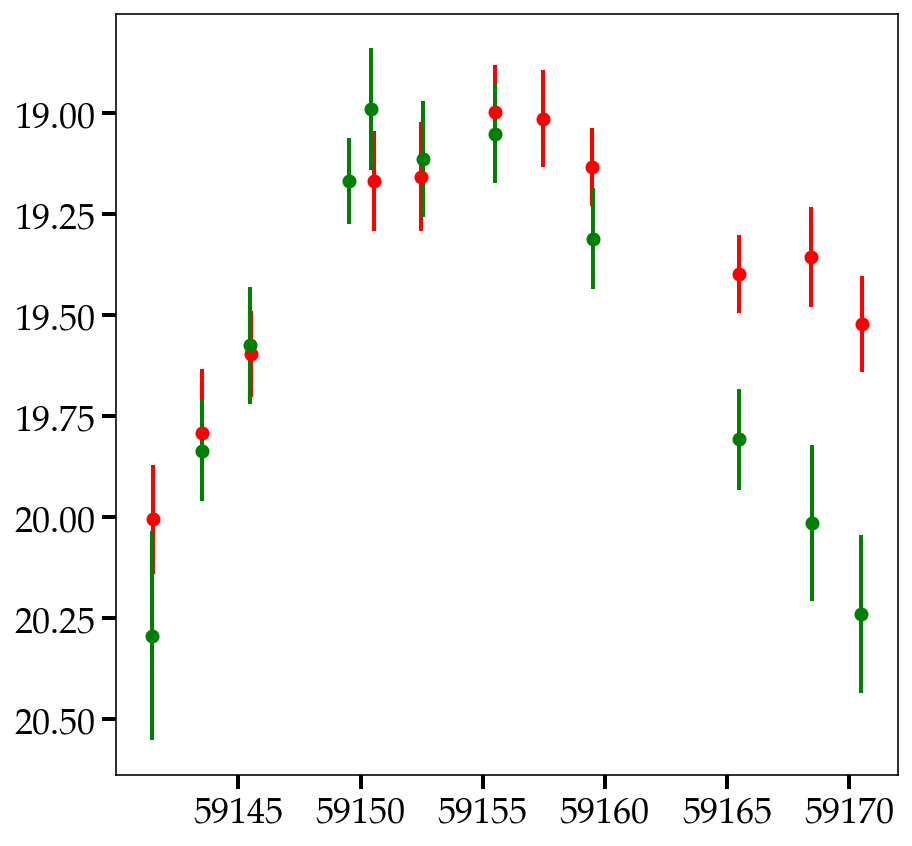

In [712]:
fig, ax = plt.subplots(figsize=(7,7))
plt.gca().invert_yaxis()

ax.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}')
ax.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# Extract LC features

In [713]:
def replace_magn_with_flux(s):
    if 'magnitude' in s:
        return s.replace('magnitudes', 'fluxes').replace('magnitude', 'flux')
    return f'{s} for flux light curve'

def create_base_features_class(
        magn_extractor,
        flux_extractor,
        bands=('R', 'g',),
    ):
    feature_names = ([f'{name}_magn' for name in magn_extractor.names]
                     + [f'{name}_flux' for name in flux_extractor.names])
    
    property_names = {band: [f'feature_{name}_{band}'.lower()
                             for name in feature_names]
                      for band in bands}
    
    features_count = len(feature_names)
    
    return feature_names, property_names, features_count


MAGN_EXTRACTOR = lc.Extractor(
    lc.Amplitude(),
    lc.AndersonDarlingNormal(),
    lc.BeyondNStd(1.0),
    lc.BeyondNStd(2.0),
    lc.Cusum(),
    lc.EtaE(),
    lc.InterPercentileRange(0.02),
    lc.InterPercentileRange(0.1),
    lc.InterPercentileRange(0.25),
    lc.Kurtosis(),
    lc.LinearFit(),
    lc.LinearTrend(),
    lc.MagnitudePercentageRatio(0.4, 0.05),
    lc.MagnitudePercentageRatio(0.2, 0.05),
    lc.MaximumSlope(),
    lc.Mean(),
    lc.MedianAbsoluteDeviation(),
    lc.PercentAmplitude(),
    lc.PercentDifferenceMagnitudePercentile(0.05),
    lc.PercentDifferenceMagnitudePercentile(0.1),
    lc.MedianBufferRangePercentage(0.1),
    lc.MedianBufferRangePercentage(0.2),
    lc.Periodogram(
        peaks=5,
        resolution=10.0,
        max_freq_factor=2.0,
        nyquist='average',
        fast=True,
        features=(
            lc.Amplitude(),
            lc.BeyondNStd(2.0),
            lc.BeyondNStd(3.0),
            lc.StandardDeviation(),
        ),
    ),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StandardDeviation(),
    lc.StetsonK(),
    lc.WeightedMean(),
)

FLUX_EXTRACTOR = lc.Extractor(
    lc.AndersonDarlingNormal(),
    lc.Cusum(),
    lc.EtaE(),
    lc.ExcessVariance(),
    lc.Kurtosis(),
    lc.MeanVariance(),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StetsonK(),
)

def remove_simultaneous_alerts(table):
    """Remove alert duplicates"""
    dt = np.diff(table['ant_mjd'], append=np.inf)
    return table[dt != 0]
    
def get_detections(photometry, band):
    """Extract clean light curve in given band from locus photometry"""
    band_lc = photometry[(photometry['ant_passband'] == band) & (~photometry['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    detections = remove_simultaneous_alerts(band_lc[idx])
    return detections

min_obs_count=4
cls_name='BaseFeatures'

lightcurve = ref_info.lightcurve
feature_names, property_names, features_count = create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)


g_obs = list(get_detections(lightcurve, 'g').ant_mjd.values)
r_obs = list(get_detections(lightcurve, 'R').ant_mjd.values)
mjd_l = sorted(g_obs+r_obs)

lc_properties_d_l = []
len_det_counter_r,len_det_counter_g = 0,0

band_lc = lightcurve[(~lightcurve['ant_mag'].isna())]
idx = ~MaskedColumn(band_lc['ant_mag']).mask
all_detections = remove_simultaneous_alerts(band_lc[idx])
for ob, mjd in enumerate(mjd_l): # requires 4 obs
    # do time evolution of detections - in chunks
    
    detections_pb = all_detections[all_detections['ant_mjd'].values <= mjd]
    #print(detections)
    lc_properties_d={}
    for band, names in property_names.items():
        detections = detections_pb[detections_pb['ant_passband'] == band]
        
        # Ensure locus has >3 obs for calculation
        if (len(detections) < min_obs_count):
            continue
        #print(detections)
        
        t = detections['ant_mjd'].values
        m = detections['ant_mag'].values
        merr = detections['ant_magerr'].values
        flux = np.power(10.0, -0.4 * m)
        fluxerr = 0.5 * flux * (np.power(10.0, 0.4 * merr) - np.power(10.0, -0.4 * merr))

        magn_features = MAGN_EXTRACTOR(
            t,
            m,
            merr,
            fill_value=None,
        )
        flux_features = FLUX_EXTRACTOR(
            t,
            flux,
            fluxerr,
            fill_value=None,
        )

        # After successfully calculating features, set locus properties and tag
        lc_properties_d["obs_num"] = int(ob)
        lc_properties_d["mjd_cutoff"] = mjd
        lc_properties_d["ztf_object_id"] = ztf_id_ref
        #print(band, m)
        for name, value in zip(names, chain(magn_features, flux_features)):
            lc_properties_d[name] = value
            #if name == "feature_amplitude_magn_g": print(m, value, band)
        #print("%%%%%%%%")
    lc_properties_d_l.append(lc_properties_d)
print("Done!")

lc_properties_d_l = [d for d in lc_properties_d_l if d]

Done!


In [714]:
lc_properties_d

{'obs_num': 21,
 'mjd_cutoff': 59170.52946759993,
 'ztf_object_id': 'ZTF20aclgnds',
 'feature_amplitude_magn_r': 0.5041980743408203,
 'feature_anderson_darling_normal_magn_r': 0.36268064723245097,
 'feature_beyond_1_std_magn_r': 0.36363636363636365,
 'feature_beyond_2_std_magn_r': 0.0,
 'feature_cusum_magn_r': 0.39352828832490466,
 'feature_eta_e_magn_r': 0.34045320848510624,
 'feature_inter_percentile_range_2_magn_r': 1.0083961486816406,
 'feature_inter_percentile_range_10_magn_r': 0.8700255526166529,
 'feature_inter_percentile_range_25_magn_r': 0.43943119049072266,
 'feature_kurtosis_magn_r': -0.3689313738406601,
 'feature_linear_fit_slope_magn_r': -0.011159288896031664,
 'feature_linear_fit_slope_sigma_magn_r': 0.0038956616176460367,
 'feature_linear_fit_reduced_chi2_magn_r': 6.316798546510648,
 'feature_linear_trend_magn_r': -0.014020273308725817,
 'feature_linear_trend_sigma_magn_r': 0.009905317408070375,
 'feature_linear_trend_noise_magn_r': 0.3112042081281197,
 'feature_magnitud

In [715]:
lc_properties_d_l

[{'obs_num': 6,
  'mjd_cutoff': 59149.51124999998,
  'ztf_object_id': 'ZTF20aclgnds',
  'feature_amplitude_magn_g': 0.5625495910644531,
  'feature_anderson_darling_normal_magn_g': 0.06930359030433288,
  'feature_beyond_1_std_magn_g': 0.5,
  'feature_beyond_2_std_magn_g': 0.0,
  'feature_cusum_magn_g': 0.36719488090631547,
  'feature_eta_e_magn_g': 0.8367328679601871,
  'feature_inter_percentile_range_2_magn_g': 1.1250991821289062,
  'feature_inter_percentile_range_10_magn_g': 1.1250991821289062,
  'feature_inter_percentile_range_25_magn_g': 0.6928462982177734,
  'feature_kurtosis_magn_g': 0.06820546466777166,
  'feature_linear_fit_slope_magn_g': -0.11950855480478284,
  'feature_linear_fit_slope_sigma_magn_g': 0.023669595044599933,
  'feature_linear_fit_reduced_chi2_magn_g': 0.3743115508898929,
  'feature_linear_trend_magn_g': -0.13473146811715042,
  'feature_linear_trend_sigma_magn_g': 0.019344499225914493,
  'feature_linear_trend_noise_magn_g': 0.1149624894319997,
  'feature_magnitude

In [716]:
feats = ['feature_amplitude_magn_r',
 'feature_anderson_darling_normal_magn_r',
 'feature_beyond_1_std_magn_r',
 'feature_beyond_2_std_magn_r',
 'feature_cusum_magn_r',
 'feature_inter_percentile_range_2_magn_r',
 'feature_inter_percentile_range_10_magn_r',
 'feature_inter_percentile_range_25_magn_r',
 'feature_kurtosis_magn_r',
 'feature_linear_fit_slope_magn_r',
 'feature_linear_fit_slope_sigma_magn_r',
 'feature_magnitude_percentage_ratio_40_5_magn_r',
 'feature_magnitude_percentage_ratio_20_5_magn_r',
 'feature_mean_magn_r',
 'feature_median_absolute_deviation_magn_r',
 'feature_percent_amplitude_magn_r',
 'feature_median_buffer_range_percentage_10_magn_r',
 'feature_median_buffer_range_percentage_20_magn_r',
 'feature_percent_difference_magnitude_percentile_5_magn_r',
 'feature_percent_difference_magnitude_percentile_10_magn_r',
 'feature_skew_magn_r',
 'feature_standard_deviation_magn_r',
 'feature_stetson_k_magn_r',
 'feature_weighted_mean_magn_r',
 'feature_anderson_darling_normal_flux_r',
 'feature_cusum_flux_r',
 'feature_excess_variance_flux_r',
 'feature_kurtosis_flux_r',
 'feature_mean_variance_flux_r',
 'feature_skew_flux_r',
 'feature_stetson_k_flux_r',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation_magn_g',
 'feature_median_buffer_range_percentage_10_magn_g',
 'feature_median_buffer_range_percentage_20_magn_g',
 'feature_percent_amplitude_magn_g',
 'feature_percent_difference_magnitude_percentile_5_magn_g',
 'feature_percent_difference_magnitude_percentile_10_magn_g',
 'feature_skew_magn_g',
 'feature_standard_deviation_magn_g',
 'feature_stetson_k_magn_g',
 'feature_weighted_mean_magn_g',
 'feature_anderson_darling_normal_flux_g',
 'feature_cusum_flux_g',
 'feature_excess_variance_flux_g',
 'feature_kurtosis_flux_g',
 'feature_mean_variance_flux_g',
 'feature_skew_flux_g',
 'feature_stetson_k_flux_g']

drop_feat_cols = ['feature_eta_e_magn_r',
                 'feature_linear_fit_reduced_chi2_magn_r', 
                 'feature_linear_trend_magn_r', # cadence removal
                 'feature_linear_trend_sigma_magn_r',  # cadence removal
                 'feature_linear_trend_noise_magn_r',  # cadence removal
                 'feature_maximum_slope_magn_r',
                 'feature_period_0_magn_r',  # should be negated
                 'feature_period_s_to_n_0_magn_r', # cadence removal
                 'feature_period_1_magn_r', 
                 'feature_period_s_to_n_1_magn_r', # cadence removal
                 'feature_period_2_magn_r', 
                 'feature_period_s_to_n_2_magn_r', # cadence removal
                 'feature_period_3_magn_r', 
                 'feature_period_s_to_n_3_magn_r', # cadence removal
                 'feature_period_4_magn_r', 
                 'feature_period_s_to_n_4_magn_r', # cadence removal
                 'feature_periodogram_amplitude_magn_r',
                 'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                 'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                 'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                 'feature_chi2_magn_r',
                 'feature_eta_e_flux_r', 
                 'feature_chi2_flux_r', 
                 'feature_eta_e_magn_g',
                 'feature_linear_fit_reduced_chi2_magn_g', 
                 'feature_linear_trend_magn_g', # cadence removal
                 'feature_linear_trend_sigma_magn_g',  # cadence removal
                 'feature_linear_trend_noise_magn_g',
                 'feature_maximum_slope_magn_g', 
                 'feature_period_0_magn_g',  # should be negated
                 'feature_period_s_to_n_0_magn_g', # cadence removal
                 'feature_period_1_magn_g', 
                 'feature_period_s_to_n_1_magn_g', # cadence removal
                 'feature_period_2_magn_g', 
                 'feature_period_s_to_n_2_magn_g', # cadence removal
                 'feature_period_3_magn_g', 
                 'feature_period_s_to_n_3_magn_g', # cadence removal
                 'feature_period_4_magn_g', 
                 'feature_period_s_to_n_4_magn_g', # cadence removal
                 'feature_periodogram_amplitude_magn_g',
                 'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                 'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                 'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                 'feature_chi2_magn_g',
                 'feature_eta_e_flux_g', 
                 'feature_chi2_flux_g',]

In [717]:
len(feats)

62

In [718]:
lc_properties_df = pd.DataFrame(lc_properties_d_l)
#lc_properties_df.set_index('ztf_object_id')

#lc_properties_df = lc_properties_df.drop(columns=drop_feat_cols)
#lc_properties_df = lc_properties_df.set_index('ztf_object_id')
lc_properties_df

,obs_num,mjd_cutoff,ztf_object_id,feature_amplitude_magn_g,feature_anderson_darling_normal_magn_g,feature_beyond_1_std_magn_g,feature_beyond_2_std_magn_g,feature_cusum_magn_g,feature_eta_e_magn_g,feature_inter_percentile_range_2_magn_g,...,feature_weighted_mean_magn_r,feature_anderson_darling_normal_flux_r,feature_cusum_flux_r,feature_eta_e_flux_r,feature_excess_variance_flux_r,feature_kurtosis_flux_r,feature_mean_variance_flux_r,feature_chi2_flux_r,feature_skew_flux_r,feature_stetson_k_flux_r
0,6,59149.511250,ZTF20aclgnds,0.562550,0.069304,0.500000,0.0,0.367195,0.836733,1.125099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,59150.432847,ZTF20aclgnds,0.651689,0.142779,0.400000,0.0,0.377660,0.530212,1.303377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,59150.530405,ZTF20aclgnds,0.651689,0.142779,0.400000,0.0,0.377660,0.530212,1.303377,...,19.605029,0.122297,0.348471,0.541998,0.104676,1.544123,0.346242,6.440929,1.230006,0.846750
3,9,59152.485660,ZTF20aclgnds,0.651689,0.142779,0.400000,0.0,0.377660,0.530212,1.303377,...,19.523781,0.290152,0.418387,0.291839,0.099398,-2.775628,0.339460,7.263210,0.226320,0.880646
4,10,59152.535058,ZTF20aclgnds,0.651689,0.290615,0.333333,0.0,0.402558,0.458617,1.303377,...,19.523781,0.290152,0.418387,0.291839,0.099398,-2.775628,0.339460,7.263210,0.226320,0.880646
5,11,59155.493912,ZTF20aclgnds,0.651689,0.290615,0.333333,0.0,0.402558,0.458617,1.303377,...,19.421220,0.310492,0.433108,0.243654,0.107908,-2.180244,0.350581,9.175299,-0.026388,0.872296
6,12,59155.511759,ZTF20aclgnds,0.651689,0.492115,0.142857,0.0,0.410630,0.453740,1.303377,...,19.421220,0.310492,0.433108,0.243654,0.107908,-2.180244,0.350581,9.175299,-0.026388,0.872296
7,13,59157.462627,ZTF20aclgnds,0.651689,0.492115,0.142857,0.0,0.410630,0.453740,1.303377,...,19.357947,0.434019,0.436383,0.178197,0.098768,-1.993907,0.336714,9.848283,-0.355551,0.911299
8,14,59159.464861,ZTF20aclgnds,0.651689,0.492115,0.142857,0.0,0.410630,0.453740,1.303377,...,19.314354,0.577658,0.431483,0.202207,0.083686,-1.512171,0.311807,10.068921,-0.605340,0.933373
9,15,59159.511690,ZTF20aclgnds,0.651689,0.511843,0.125000,0.0,0.398881,0.564524,1.303377,...,19.314354,0.577658,0.431483,0.202207,0.083686,-1.512171,0.311807,10.068921,-0.605340,0.933373


lc_properties_df = pd.DataFrame.from_dict(lc_properties_d, orient='index').T
#lc_properties_df.set_index('ztf_object_id')

lc_properties_df = lc_properties_df.drop(columns=drop_feat_cols)
lc_properties_df.set_index('ztf_object_id')

# Get GHOST features

In [719]:
%%time

import astro_ghost
from astro_ghost.ghostHelperFunctions import getTransientHosts, getGHOST
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime
import tempfile

# Throw RA/DEC into ghost with just DLR method, gentle starcut
# Sets environ var to find ghost.csv
os.environ['GHOST_PATH'] = './host_info'
# Then don't use getGHOST(real=True, verbose=verbose)
getGHOST(real=True,verbose=False)

ra,dec=np.mean(df_ref.ant_ra),np.mean(df_ref.ant_dec)
print(ra,dec)

snName=[ztf_id_ref, ztf_id_ref]
snCoord = [SkyCoord(ra*u.deg, dec*u.deg, frame='icrs'), SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')]
print(snCoord)
with tempfile.TemporaryDirectory() as tmp:
    hosts = getTransientHosts(snName=snName, snCoord=snCoord, verbose=0, starcut='gentle', ascentMatch=False, savepath=tmp)
    # Save
    #hosts.to_csv(f'../loci_dbs/alerce_cut/dataset_bank_hosts_start_idx-end_idx={start_idx}-{end_idx}.csv.gz', compression='gzip', index=False)
    #print("Saved!\n#############")
if len(hosts) > 1:
    hosts = pd.DataFrame(hosts.loc[0]).T
    
hosts

GHOST database already exists in the install path!
139.33892297272726 33.88877446818182
[<SkyCoord (ICRS): (ra, dec) in deg
    (139.33892297, 33.88877447)>, <SkyCoord (ICRS): (ra, dec) in deg
    (139.33892297, 33.88877447)>]
Finding northern sources with Pan-starrs...
Found matches for 50.0% of events.
CPU times: user 2.72 s, sys: 218 ms, total: 2.93 s
Wall time: 6.9 s


,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,...,yApMag_yKronMag,7DCD,hasSimbad,class,dist/DLR,dist,TransientClass,TransientName,TransientRA,TransientDEC
0,PSO J091721.197+335317.892,NaN,NaN,NaN,148661393384266604,1048281000134780,214104119840382,0,16488487215495,14866,...,0.499899,18.244854,0,False,0.344077,2.426751,NaN\nNaN,ZTF20aclgnds\nZTF20aclgnds,139.338923,33.888774


In [720]:
print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={hosts.raMean.values[0]}+{hosts.decMean.values[0]}&filter=color')

http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=139.33832939+33.88831446&filter=color


In [721]:
# Define the label array
label_arr = np.array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
                     'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'])

# Define the spectroscopic class
spec_class = spec_class

# Find the index of the spectroscopic class in the label array
class_index = np.where(label_arr == spec_class)[0]

# Create a one-hot encoded array with all zeros
onehot_array = np.zeros(len(label_arr), dtype=float)

# Set the corresponding index to 1
onehot_array[class_index] = 1

# Reshape the array to have a shape of (1, num_classes)
onehot_array = onehot_array.reshape(1, -1)

# Print the one-hot encoded label
print(onehot_array)


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [722]:
onehot_df = pd.DataFrame(np.array(onehot_array, dtype=float), columns=label_arr)
onehot_df = pd.concat([onehot_df] * len(lc_properties_df), ignore_index=True)
onehot_df

,None,SLSN-II,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [723]:
hosts_df = hosts[feature_names_hostgal]
hosts_df = pd.concat([hosts_df] * len(lc_properties_df), ignore_index=True)

lc_and_hosts_df = pd.concat([lc_properties_df, hosts_df, onehot_df], axis=1)
lc_and_hosts_df = lc_and_hosts_df.set_index('ztf_object_id')
lc_and_hosts_df.to_csv(f'{df_path}/{lc_and_hosts_df.index[0]}_timeseries.csv')
lc_and_hosts_df

,obs_num,mjd_cutoff,feature_amplitude_magn_g,feature_anderson_darling_normal_magn_g,feature_beyond_1_std_magn_g,feature_beyond_2_std_magn_g,feature_cusum_magn_g,feature_eta_e_magn_g,feature_inter_percentile_range_2_magn_g,feature_inter_percentile_range_10_magn_g,...,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20aclgnds,6,59149.511250,0.562550,0.069304,0.500000,0.0,0.367195,0.836733,1.125099,1.125099,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZTF20aclgnds,7,59150.432847,0.651689,0.142779,0.400000,0.0,0.377660,0.530212,1.303377,1.303377,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZTF20aclgnds,8,59150.530405,0.651689,0.142779,0.400000,0.0,0.377660,0.530212,1.303377,1.303377,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZTF20aclgnds,9,59152.485660,0.651689,0.142779,0.400000,0.0,0.377660,0.530212,1.303377,1.303377,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZTF20aclgnds,10,59152.535058,0.651689,0.290615,0.333333,0.0,0.402558,0.458617,1.303377,1.245226,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZTF20aclgnds,11,59155.493912,0.651689,0.290615,0.333333,0.0,0.402558,0.458617,1.303377,1.245226,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZTF20aclgnds,12,59155.511759,0.651689,0.492115,0.142857,0.0,0.410630,0.453740,1.303377,1.199576,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZTF20aclgnds,13,59157.462627,0.651689,0.492115,0.142857,0.0,0.410630,0.453740,1.303377,1.199576,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZTF20aclgnds,14,59159.464861,0.651689,0.492115,0.142857,0.0,0.410630,0.453740,1.303377,1.199576,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [724]:
for f, v in zip(lc_and_hosts_df.columns, lc_and_hosts_df.iloc[-1, :].values):
    print(f,v)

obs_num 21.0
mjd_cutoff 59170.52946759993
feature_amplitude_magn_g 0.6516885757446289
feature_anderson_darling_normal_magn_g 0.4461019236192039
feature_beyond_1_std_magn_g 0.36363636363636365
feature_beyond_2_std_magn_g 0.0
feature_cusum_magn_g 0.4291067566242199
feature_eta_e_magn_g 0.5316052797243762
feature_inter_percentile_range_2_magn_g 1.3033771514892578
feature_inter_percentile_range_10_magn_g 1.2345706720018406
feature_inter_percentile_range_25_magn_g 0.8422942161560023
feature_kurtosis_magn_g -1.581861344486283
feature_linear_fit_slope_magn_g 0.012202505465547716
feature_linear_fit_slope_sigma_magn_g 0.0050915087314198585
feature_linear_fit_reduced_chi2_magn_g 9.067106742881636
feature_linear_trend_magn_g 0.010377147687128298
feature_linear_trend_sigma_magn_g 0.01561741870274263
feature_linear_trend_noise_magn_g 0.4975607412058675
feature_magnitude_percentage_ratio_40_5_magn_g 0.3963228330128345
feature_magnitude_percentage_ratio_20_5_magn_g 0.7607019111141418
feature_maximum_

hosts_df = hosts[feature_names_hostgal]

lc_and_hosts_df = pd.concat([lc_properties_df, hosts_df, onehot_df], axis=1)
lc_and_hosts_df = lc_and_hosts_df.set_index('ztf_object_id')
lc_and_hosts_df.to_csv(f'{df_path}/{lc_and_hosts_df.index[0]}.csv')
lc_and_hosts_df

In [725]:
lc_and_hosts_df.index[0]

'ZTF20aclgnds'